In [ ]:
!pip install nltk
!pip install spacy
!python -m spacy download es_core_news_sm
!pip install -U imbalanced-learn
!pip install pyspellchecker


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Oculta warnings
import warnings
warnings.simplefilter('ignore')

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# CARGAR DATOS
**DATOS DE ENTRENAMIENTO**

la columna de trastornos indica si el TWEET es de una persona con depresión o es de control.


**control**:     0

**depresión**:   1

**ansiedad**:    2

In [ ]:
ruta_archivo_entrenamiento = '/content/drive/MyDrive/Experimentación Python Tesis /Data: A D C/train.csv'
data_train = pd.read_csv(ruta_archivo_entrenamiento, sep=',')
data_train.info()
data_train.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97543 entries, 0 to 97542
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   USER_ID     65054 non-null  object 
 1   TWEET_ID    64990 non-null  float64
 2   TWEET_TEXT  97479 non-null  object 
 3   trastorno   97543 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 3.0+ MB


,USER_ID,TWEET_ID,TWEET_TEXT,trastorno
0,47,2.147484e+09,RT @FraRocanroleras: Te estás destruyendo y lo...,1
1,6,2.147484e+09,No sé cómo estar sin ti pero tampoco sé cómo e...,0
2,NaN,NaN,Me pregunto por qué últimamente no me siento ...,2
3,NaN,NaN,Mi ansiedad en torno a toda esta enfermedad s...,2
4,NaN,NaN,Esto ha estado en mi mente bastante durante lo...,2
5,NaN,NaN,¿Necesitas algunas ideas? Este canal es maravi...,2
6,31,2.147484e+09,"Intenté decir algo pero no pude,sólo quedé con...",0
7,27,2.147484e+09,tumblrbot ha preguntado: ROBOTS OR DINOSAURS? ...,1
8,49,2.147484e+09,El smirnoff es la bebida mas traicionera que e...,1
9,36,2.147484e+09,¿Por qué mis primas son delgadas y tan hermosa...,0


In [ ]:
# Verificar si hay filas nulas o vacías en la columna 'TWEET_TEXT'
null_values = data_train['TWEET_TEXT'].isnull().sum()

# Imprimir el número de filas nulas o vacías
print("Número de filas nulas o vacías en la columna 'TWEET_TEXT':", null_values)

Número de filas nulas o vacías en la columna 'TWEET_TEXT': 64


In [ ]:
data_train.dropna(subset=['TWEET_TEXT'], inplace=True)

# Verificar si hay filas nulas o vacías en la columna 'TWEET_TEXT'
null_values = data_train['TWEET_TEXT'].isnull().sum()

# Imprimir el número de filas nulas o vacías
print("Número de filas nulas o vacías en la columna 'TWEET_TEXT':", null_values)
data_train.info()

Número de filas nulas o vacías en la columna 'TWEET_TEXT': 0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 97479 entries, 0 to 97542
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   USER_ID     64990 non-null  object 
 1   TWEET_ID    64990 non-null  float64
 2   TWEET_TEXT  97479 non-null  object 
 3   trastorno   97479 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 3.7+ MB


#Preprocesamiento de los datos

In [ ]:
import nltk
nltk.download('stopwords')  #Solamente se ha de descargar la primera vez.
stopwords_es = nltk.corpus.stopwords.words('spanish')   # Extrae las stopwords en español

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


*Eliminar etiquetas HTML*

In [ ]:
import re

def removeHTML(text):
    if isinstance(text, str):  # Verificar si es de tipo string
        cleanr = re.compile('<.*?>')
        cleantext = re.sub(cleanr, '', text)
        return cleantext
    else:
        return text  # Devolver el valor original si no es de tipo string

*Limpieza del texto*

In [ ]:
import re
import string

def clean(text):
    if isinstance(text, str):  # Verificar si es de tipo string
        # Eliminar hashtags
        text = re.sub(r'#\w+', '', text)

        # Eliminar URLs o enlaces
        text = re.sub(r'(https?://)?[a-zA-Z0-9]+\.[a-zA-Z0-9]+\S*', '', text)

        # Eliminar nombres de usuarios de Twitter
        text = re.sub(r'@\w+', '', text)

        # Eliminar Nombres propios
        text = re.sub(r'\b[A-Z][a-z]+\b', '', text)

        # Eliminar todos los caracteres especiales
        text = re.sub(r'[^\w\s]+', '', text)

        # Eliminar prefijos y números
        text = re.sub(r'\b\w{1,2}\b|\d+', '', text)

        # Eliminar palabras específicas
        specific_words = ['retweet', 'retweets', 'hashtag', 'trending', 'mención', 'enlace', 'emoji', 'timeline', 'interacciones',
                          'tuit', 'seguidores', 'notificaciones', 'seguir', 'favorito', 'perfil', 'tendencia', 'influencer',
                          'compartir', 'actualización', 'explorar', 'seguir', 'comunidad', 'contenido', 'popular',
                          'recomendar', 'experiencia', 'conectar', 'comentar', 'compartir', 'comunidad', 'actualización',
                          'drk', 'followers', 'stats', 'for', 'new', 'little', 'unfollower', 'unfollowers', 'today', 'shit','twitter','nombre',
                          'eric','story','great', 'short','squeeze','piggly','wiggly','hmv','even','follas','you','i','he','she',
                          'it','we','they','the','and','that','these','those','tweet','followed','follower']
        text = ' '.join([word for word in text.split() if word not in specific_words])

        # Eliminar emojis
        emojis = re.findall(r'[^\w\s,]', text)
        cleaned_emojis = [emoji for emoji in emojis if emoji not in ['@', '#', '/', '?','¿','.','…','"',':','“','!','¡','°','-',"‘",'’',
                                                                     '=',';','(',')',"'","'",'&','€','%','$','*','+','|', '”','🇦','🇷',',',
                                                                     ', ','—','«',' »','»','« ','[, ]','[,]',',',', ','',' ',' ♀',' 🏽']]
        for emoji in cleaned_emojis:
            text = text.replace(emoji, '')

        # Convertir el texto a minúsculas
        text = text.lower()

        # Eliminar signos de puntuación
        text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
        # Tokenizar el texto en palabras
        words = text.split()

        # Reconstruir el texto limpio
        text = ' '.join(words)

        # Devuelve el texto limpio
        return text
    else:
        return text  # Devolver el valor original si no es de tipo string

*lematizar y extraer términos*

In [ ]:
import pandas as pd
import spacy
from spacy.lang.es import Spanish
from nltk.corpus import stopwords


# Cargar modelo de spaCy
nlp = spacy.load("es_core_news_sm")

# Cargar stopwords en español
stopwords_es = set(stopwords.words('spanish'))

def extractTerms(text):
    if isinstance(text, str):
        # Tokenización y lematización con spaCy
        doc = nlp(text)
        lemmatized_terms = [token.lemma_ for token in doc if token.text.lower() not in stopwords_es]

        return lemmatized_terms
    else:
        return []  # Devolver una lista vacía si el texto no es una cadena de texto

# Ejemplo de uso
texto_ejemplo = "Los gatos están saltando sobre las vallas"
terminos_extraidos = extractTerms(texto_ejemplo)
print(terminos_extraidos)

['gato', 'saltar', 'valla']


# Preprocesamieto del conjunto de datos de entrenamiento

In [ ]:
def Tokenizer(text):
    if isinstance(text, str):
        return text.split()
    else:
        return []  # Si el valor no es una cadena, retornar una lista vacía


In [ ]:
data_train['TWEET_TEXT'] = data_train['TWEET_TEXT'].apply(removeHTML)
data_train['TWEET_TEXT'] = data_train['TWEET_TEXT'].apply(clean)

#data_train['TWEET_TEXT'] = data_train['TWEET_TEXT'].apply(extractTerms)
data_train['TWEET_TEXT'] = data_train['TWEET_TEXT'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x) # Combinar los elementos de la lista en una sola cadena separados por espacios
data_train.info()
data_train.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97479 entries, 0 to 97542
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   USER_ID     64990 non-null  object 
 1   TWEET_ID    64990 non-null  float64
 2   TWEET_TEXT  97479 non-null  object 
 3   trastorno   97479 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 3.7+ MB


,USER_ID,TWEET_ID,TWEET_TEXT,trastorno
0,47,2.147484e+09,estás destruyendo único que haces reírte,1
1,6,2.147484e+09,cómo estar sin pero tampoco cómo estar contigo,0
2,NaN,NaN,pregunto por qué últimamente siento tranquilo ...,2
3,NaN,NaN,ansiedad torno toda esta enfermedad disparado,2
4,NaN,NaN,estado mente bastante durante los últimos mese...,2
5,NaN,NaN,algunas ideas canal maravilloso está aquí pero...,2
6,31,2.147484e+09,intenté decir algo pero pudesólo quedé con ese...,0
7,27,2.147484e+09,tumblrbot preguntado robots dinosaurs,1
8,49,2.147484e+09,smirnoff bebida mas traicionera que existe cha...,1
9,36,2.147484e+09,qué mis primas son delgadas tan hermosas qué s...,0


In [ ]:
# Verificar si hay valores NaN o nulos en la columna 'TWEET_TEXT'
conteo_nulos = data_train['TWEET_TEXT'].isnull().sum()

if conteo_nulos > 0:
    # Filtrar los valores NaN o nulos antes de aplicar len()
    datos_no_nulos = data_train[~data_train['TWEET_TEXT'].isnull()]
    conteo_vacios = (datos_no_nulos['TWEET_TEXT'].apply(len) == 0).sum()
else:
    # Si no hay valores NaN o nulos, puedes aplicar len() directamente
    conteo_vacios = (data_train['TWEET_TEXT'].apply(len) == 0).sum()

# Imprimir el número de elementos vacíos
print("Número de elementos vacíos en la columna 'TWEET_TEXT':", conteo_vacios)


Número de elementos vacíos en la columna 'TWEET_TEXT': 5218


In [ ]:
# Filtrar filas donde 'TWEET_TEXT' no sea una lista vacía
data_train['TWEET_TEXT'] = data_train['TWEET_TEXT'].fillna('')

# Filtrar filas donde 'TWEET_TEXT' no sea una cadena vacía
data_train = data_train[data_train['TWEET_TEXT'].apply(lambda x: len(str(x)) > 0)]

# Reiniciar el índice del DataFrame después de eliminar filas
data_train.reset_index(drop=True, inplace=True)

In [ ]:
# Verificar si hay valores NaN o nulos en la columna 'TWEET_TEXT'
conteo_nulos = data_train['TWEET_TEXT'].isnull().sum()

if conteo_nulos > 0:
    # Filtrar los valores NaN o nulos antes de aplicar len()
    datos_no_nulos = data_train[~data_train['TWEET_TEXT'].isnull()]
    conteo_vacios = (datos_no_nulos['TWEET_TEXT'].apply(len) == 0).sum()
else:
    # Si no hay valores NaN o nulos, puedes aplicar len() directamente
    conteo_vacios = (data_train['TWEET_TEXT'].apply(len) == 0).sum()

# Imprimir el número de elementos vacíos
print("Número de elementos vacíos en la columna 'TWEET_TEXT':", conteo_vacios)

Número de elementos vacíos en la columna 'TWEET_TEXT': 0


In [ ]:
data_train['TWEET_TEXT'] = data_train['TWEET_TEXT'].apply(Tokenizer)
data_train.head(10)

,USER_ID,TWEET_ID,TWEET_TEXT,trastorno
0,47,2.147484e+09,"[estás, destruyendo, único, que, haces, reírte]",1
1,6,2.147484e+09,"[cómo, estar, sin, pero, tampoco, cómo, estar,...",0
2,NaN,NaN,"[pregunto, por, qué, últimamente, siento, tran...",2
3,NaN,NaN,"[ansiedad, torno, toda, esta, enfermedad, disp...",2
4,NaN,NaN,"[estado, mente, bastante, durante, los, último...",2
5,NaN,NaN,"[algunas, ideas, canal, maravilloso, está, aqu...",2
6,31,2.147484e+09,"[intenté, decir, algo, pero, pudesólo, quedé, ...",0
7,27,2.147484e+09,"[tumblrbot, preguntado, robots, dinosaurs]",1
8,49,2.147484e+09,"[smirnoff, bebida, mas, traicionera, que, exis...",1
9,36,2.147484e+09,"[qué, mis, primas, son, delgadas, tan, hermosa...",0


#Vectorización de los datos


In [ ]:
import gensim
from gensim.models import Word2Vec
# Entrena un modelo Word2Vec usando CBOW
modelW = Word2Vec(data_train['TWEET_TEXT'], vector_size=300, window=5, min_count=1, sg=0)

# Obtener la representación vectorial de un documento promediando las palabras
def document_vector(tokens, modelW):
    # Filtrar palabras que no están en el modelo
    tokens = [token for token in tokens if token in modelW.wv.key_to_index]
    if len(tokens) == 0:
        return np.zeros(modelW.vector_size)
    return np.mean([modelW.wv[token] for token in tokens], axis=0)

# Crear una matriz de características X utilizando las representaciones vectoriales de Word2Vec
X  = np.array([document_vector(tokens, modelW) for tokens in data_train['TWEET_TEXT']])

# Asegurémonos de que los valores en X_word2vec sean no negativos
X[X  < 0] = 0

# Discretizar los valores en X_word2vec en palabras
X = [[str(i) for i in vector] for vector in X]


# Obtener las etiquetas y
y = data_train['trastorno'].values

In [ ]:
# Imprimimos el la longitud de las palabras totales
print(modelW)
print(len(modelW.wv))
# Observamos el vocabulario creado
words = modelW.wv.index_to_key
print(words)

In [ ]:
# Obtener la representación vectorial de una palabra específica
vector = modelW.wv['depresión', 'ansiedad']
vector

array([[-1.86468493e-02,  6.64705396e-01, -7.07670093e-01,
         1.10174073e-02, -1.74280867e-01, -4.85265255e-01,
        -8.71087313e-02,  7.06301391e-01, -1.26461610e-01,
        -7.58025646e-02, -1.59649566e-01, -6.60946727e-01,
        -5.04282475e-01,  3.79744917e-01, -1.15468955e+00,
        -1.33384228e+00,  7.76198506e-02, -4.14081752e-01,
         1.31612694e+00,  7.11527646e-01,  7.77156889e-01,
         3.11320484e-01, -4.32362743e-02,  6.21902585e-01,
         8.37730587e-01,  1.08371034e-01, -1.35862005e+00,
        -3.61835510e-01,  5.38735747e-01, -9.86349583e-01,
        -4.78736877e-01, -2.39417017e-01,  1.12238586e-01,
         9.48973745e-02,  3.79638433e-01, -6.78994477e-01,
        -6.05228543e-01, -6.54372573e-01, -1.10779083e+00,
        -6.59648478e-01,  8.73324513e-01,  4.95198697e-01,
         1.06282532e+00,  4.99233156e-02, -3.58953893e-01,
         7.33172596e-02,  9.39729333e-01, -7.23217368e-01,
        -9.59100425e-02, -6.09190345e-01,  9.87114608e-0

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import LatentDirichletAllocation as LDA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Aplicar LDA para reducir la dimensionalidad
n_topics = 70  # Define el número de tópicos (componentes)
lda = LDA(n_components=n_topics)
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)


In [ ]:
from keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
X_train = X_train_lda
X_val = X_test_lda
y_val = y_test


# Convertir las etiquetas en codificación one-hot
num_classes = 3  # Número de clases
y_train_one_hot = to_categorical(y_train, num_classes)
y_val_one_hot = to_categorical(y_val, num_classes)

# Crear una red neuronal secuencial
model = Sequential()

# Agregar una capa de entrada con el número de características en X_train
model.add(Dense(328, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.1))  # Dropout para regularización

# Agregar una capa oculta
model.add(Dense(164, activation='relu'))
model.add(Dropout(0.1))  # Dropout para regularización

# Agregar una capa de salida con el número de clases en tu clasificación multiclase
model.add(Dense(num_classes, activation='softmax'))

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss=CategoricalCrossentropy(), metrics=[CategoricalAccuracy()])

# Entrenar el modelo en los datos de entrenamiento
history = model.fit(X_train, y_train_one_hot, epochs=10, batch_size=32, validation_data=(X_val, y_val_one_hot))

y_val_pred = model.predict(X_val)

y_val_pred_class = y_val_pred.argmax(axis=1)  # Obtener la clase con la mayor probabilidad
y_val_true_class = y_val_one_hot.argmax(axis=1)  # Usar y_val_one_hot en lugar de y_val si está codificado en one-hot

accuracy = accuracy_score(y_val_true_class, y_val_pred_class)
precision = precision_score(y_val_true_class, y_val_pred_class, average='macro')
recall = recall_score(y_val_true_class, y_val_pred_class, average='macro')
f1 = f1_score(y_val_true_class, y_val_pred_class, average='macro')

y_train_pred = model.predict(X_train)

# Calcular métricas de evaluación en el conjunto de entrenamiento
y_train_pred_class = y_train_pred.argmax(axis=1)  # Obtener la clase con la mayor probabilidad
y_train_true_class = y_train_one_hot.argmax(axis=1)  # Usar y_train_one_hot en lugar de y_train si está codificado en one-hot

accuracy_train = accuracy_score(y_train_true_class, y_train_pred_class)
precision_train = precision_score(y_train_true_class, y_train_pred_class, average='macro')
recall_train = recall_score(y_train_true_class, y_train_pred_class, average='macro')
f1_train = f1_score(y_train_true_class, y_train_pred_class, average='macro')

# Guardar el modelo entrenado
model.save('/content/drive/MyDrive/Experimentación Python Tesis /Experimento Dataset Ansiedad Depresión/LDA/parametros/modelo_entrenado_multiclase.h5')

# Cargar el modelo entrenado
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Experimentación Python Tesis /Experimento Dataset Ansiedad Depresión/LDA/parametros/modelo_entrenado_multiclase.h5')


Epoch 1/10
2015/2015 [==============================] - 8s 4ms/step - loss: 0.8234 - categorical_accuracy: 0.5562 - val_loss: 0.8087 - val_categorical_accuracy: 0.5602
Epoch 2/10
2015/2015 [==============================] - 7s 4ms/step - loss: 0.8108 - categorical_accuracy: 0.5619 - val_loss: 0.8027 - val_categorical_accuracy: 0.5674
Epoch 3/10
2015/2015 [==============================] - 7s 4ms/step - loss: 0.8044 - categorical_accuracy: 0.5668 - val_loss: 0.7983 - val_categorical_accuracy: 0.5744
Epoch 4/10
2015/2015 [==============================] - 7s 4ms/step - loss: 0.8004 - categorical_accuracy: 0.5680 - val_loss: 0.8012 - val_categorical_accuracy: 0.5727
Epoch 5/10
2015/2015 [==============================] - 7s 4ms/step - loss: 0.7996 - categorical_accuracy: 0.5713 - val_loss: 0.7939 - val_categorical_accuracy: 0.5692
Epoch 6/10
2015/2015 [==============================] - 8s 4ms/step - loss: 0.7980 - categorical_accuracy: 0.5686 - val_loss: 0.7941 - val_categorical_accuracy:

In [ ]:
# Imprimir métricas de entrenamiento
print("\nMétricas en el conjunto de entrenamiento:")
print(f"Exactitud (entrenamiento): {round(accuracy_train, 2) * 100}%")
print(f"Precisión (entrenamiento): {round(precision_train, 2) * 100}%")
print(f"Recall (entrenamiento): {round(recall_train, 2) * 100}%")
print(f"F1-score (entrenamiento): {round(f1_train, 2) * 100}%")
print('-------------------------------------------------------------------------')
# Imprimir métricas de evaluación
print(f"Exactitud en el conjunto de validación: {round(accuracy, 2) * 100}%")
print(f"Precisión en el conjunto de validación: {round(precision, 2) * 100}%")
print(f"Recall en el conjunto de validación: {round(recall, 2) * 100}%")
print(f"F1-score en el conjunto de validación: {round(f1, 2) * 100}%")


Métricas en el conjunto de entrenamiento:
Exactitud (entrenamiento): 56.99999999999999%
Precisión (entrenamiento): 56.00000000000001%
Recall (entrenamiento): 56.99999999999999%
F1-score (entrenamiento): 54.0%
-------------------------------------------------------------------------
Exactitud en el conjunto de validación: 56.99999999999999%
Precisión en el conjunto de validación: 55.00000000000001%
Recall en el conjunto de validación: 56.00000000000001%
F1-score en el conjunto de validación: 53.0%


In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_val_true_class, y_val_pred_class)

# Imprimir la matriz de confusión
print("Matriz de Confusión:")
print(cm)

Matriz de Confusión:
[[5649 1940 1447]
 [5593 1809 1473]
 [1052  345 8314]]


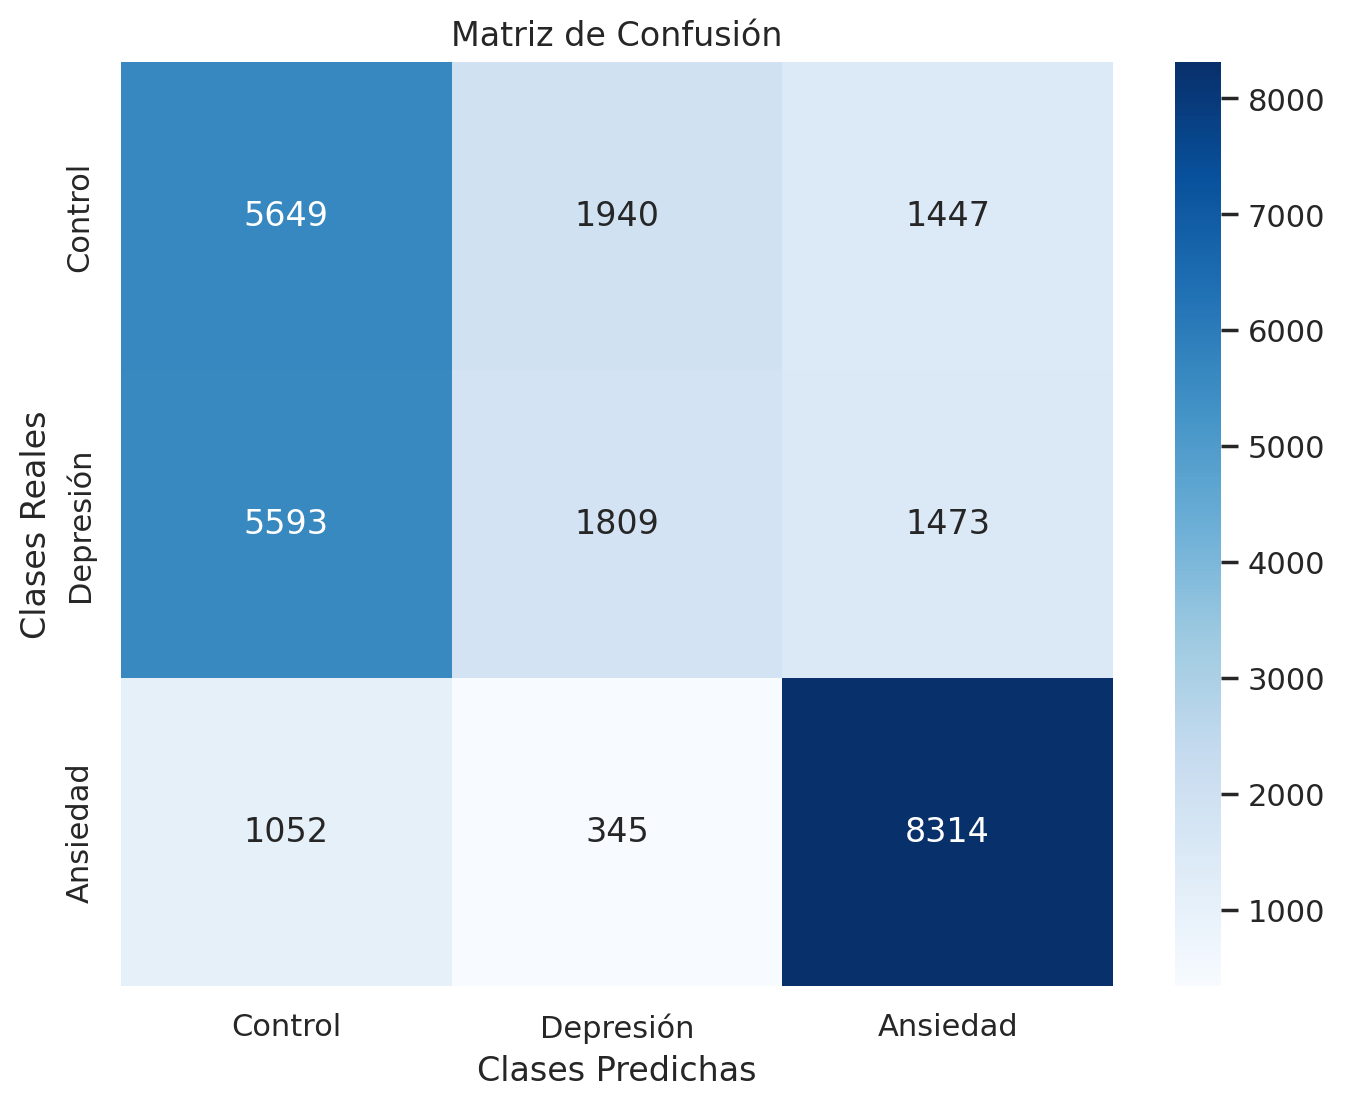

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Definir etiquetas de las clases
classes = ['Control', 'Depresión', 'Ansiedad']

# Crear un mapa de calor de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)

# Agregar etiquetas y título
plt.xlabel('Clases Predichas')
plt.ylabel('Clases Reales')
plt.title('Matriz de Confusión')

plt.show()

In [ ]:

X_train = X_train_lda
X_val = X_test_lda

y_val = y_test

#Modelo Bosque Aleatorio

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Crea un modelo de Random Forest
random_forest_model = RandomForestClassifier(
    n_estimators=500,  # Número de árboles
    max_depth=50,  # Profundidad máxima de los árboles
    random_state=42,  # Semilla aleatoria para reproducibilidad
    n_jobs=-1  # Utilizar todos los núcleos de la CPU para procesamiento en paralelo
)


# Entrena el modelo con los datos de entrenamiento
random_forest_model.fit(X_train, y_train)

# Realiza predicciones en los datos de validación
y_val_pred = random_forest_model.predict(X_val)

# Calcula e imprime la precisión del modelo en los datos de validación
accuracy = accuracy_score(y_val, y_val_pred)
print("Precisión (Validación): {:.2f}".format(accuracy))

# Calcula e imprime la precisión del modelo en los datos de validación
precision = precision_score(y_val, y_val_pred, average='weighted')
print("Precisión (Validación): {:.2f}".format(precision))

# Calcula e imprime la exhaustividad del modelo en los datos de validación
recall = recall_score(y_val, y_val_pred, average='weighted')
print("Exhaustividad (Validación): {:.2f}".format(recall))

# Calcula e imprime la puntuación F1 del modelo en los datos de validación
f1 = f1_score(y_val, y_val_pred, average='weighted')
print("Puntuación F1 (Validación): {:.2f}".format(f1))

# Calcula e imprime métricas en el conjunto de entrenamiento
y_train_pred = random_forest_model.predict(X_train)

accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred, average='weighted')
recall_train = recall_score(y_train, y_train_pred, average='weighted')
f1_train = f1_score(y_train, y_train_pred, average='weighted')

print("\nMétricas en el conjunto de entrenamiento:")
print("Precisión: {:.2f}".format(precision_train))
print("Exhaustividad: {:.2f}".format(recall_train))
print("Puntuación F1: {:.2f}".format(f1_train))

Precisión (Validación): 0.45
Precisión (Validación): 0.46
Exhaustividad (Validación): 0.45
Puntuación F1 (Validación): 0.46

Métricas en el conjunto de entrenamiento:
Precisión: 0.82
Exhaustividad: 0.82
Puntuación F1: 0.82


In [ ]:
# Imprimir las métricas de entrenamiento
print(f'Accuracy entrenamiento: {accuracy_train * 100:.2f}%')
print(f'Precisión  entrenamiento: {precision_train * 100:.2f}%')
print(f'Recall  entrenamiento: {recall_train * 100:.2f}%')
print(f'Puntuación F1  entrenamiento: {f1_train * 100:.2f}%')
print('\n')
# Imprimir las métricas de validación
print(f'Accuracy  validación: {accuracy * 100:.2f}%')
print(f'Precisión  validación: {precision* 100:.2f}%')
print(f'Recall  validación: {recall* 100:.2f}%')
print(f'Puntuación F1 validación: {f1 * 100:.2f}%')

Accuracy entrenamiento: 81.90%
Precisión  entrenamiento: 82.30%
Recall  entrenamiento: 81.90%
Puntuación F1  entrenamiento: 82.08%


Accuracy  validación: 44.93%
Precisión  validación: 46.34%
Recall  validación: 44.93%
Puntuación F1 validación: 45.60%


In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = random_forest_model.predict(X_val)

#
cm = confusion_matrix(y_val, y_pred)


#
prop_real = np.sum(y_val)/len(y_val)
prop_etiqutados = (cm[0,1]+cm[1,1])/len(y_val)
print("Matriz de confusión: \n\n", cm, "\n")

Matriz de confusión: 

 [[2180 6360  444]
 [6489 2036  462]
 [ 773  716 8219]] 



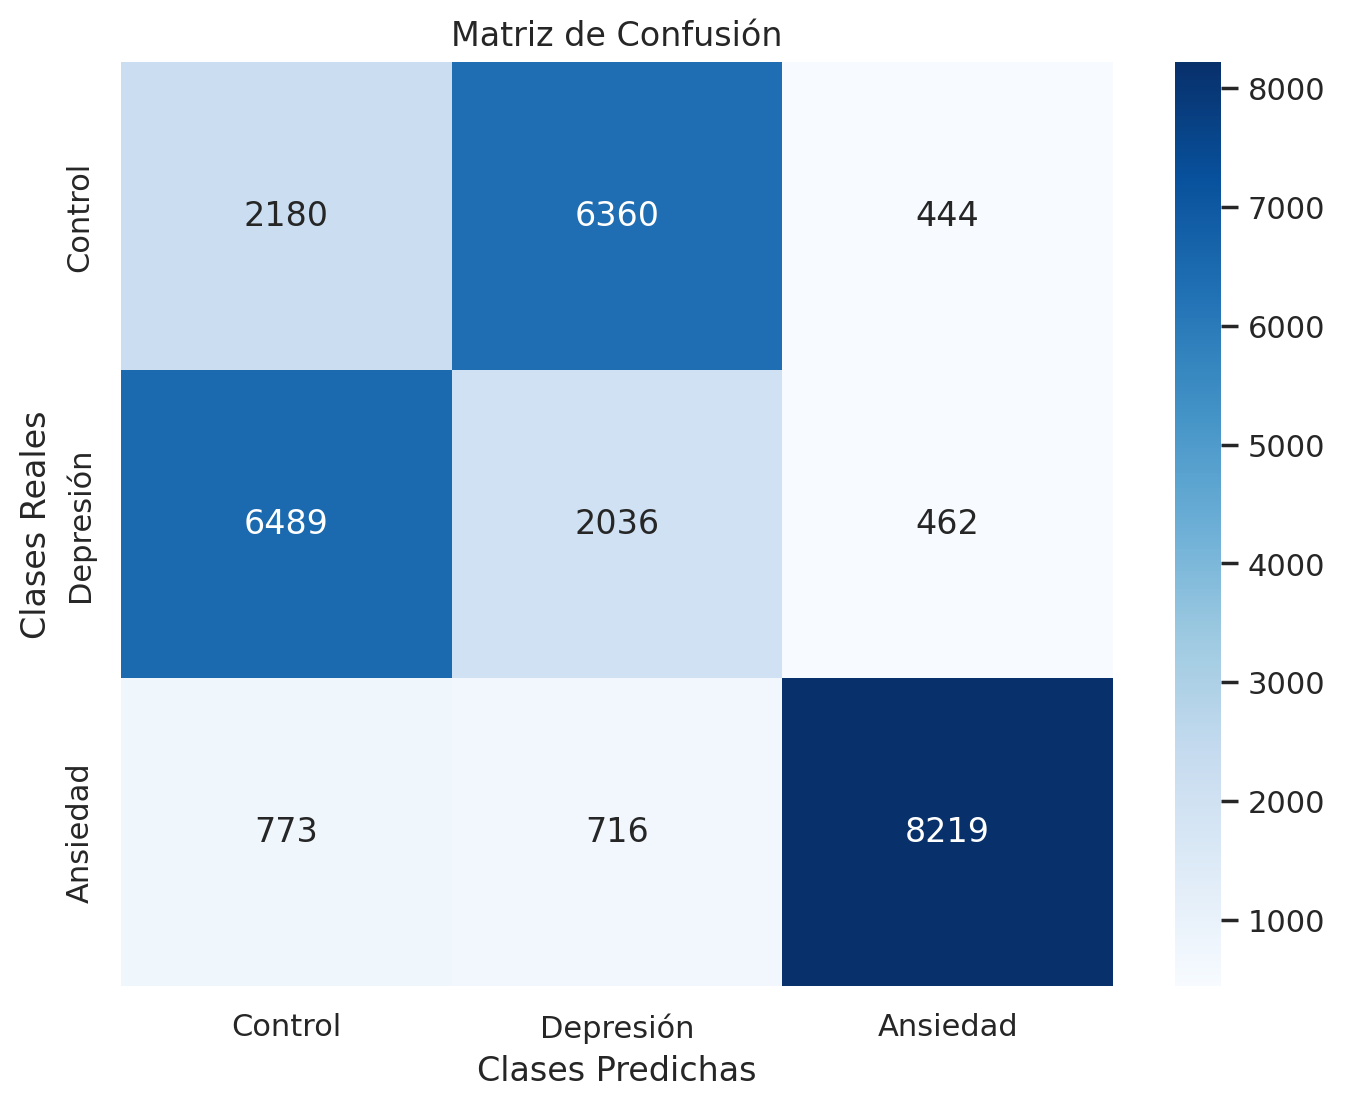

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Definir etiquetas de las clases
classes = ['Control', 'Depresión', 'Ansiedad']

# Crear un mapa de calor de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)

# Agregar etiquetas y título
plt.xlabel('Clases Predichas')
plt.ylabel('Clases Reales')
plt.title('Matriz de Confusión')

plt.show()

#Modelo SVM

In [ ]:
from sklearn.svm import SVC


# Crear un modelo SVM para clasificación multiclase con kernel polinómico
svm_model_p =SVC(kernel='sigmoid', C=100,  degree=4, gamma='scale', coef0=2.5)

# Entrenar el modelo en los datos de entrenamiento
svm_model_p.fit(X_train, y_train)

# Predecir etiquetas en el conjunto de validación
y_val_pred = svm_model_p.predict(X_val)

# Calcular las métricas en el conjunto de validación
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred, average='weighted')
recall = recall_score(y_val, y_val_pred, average='weighted')
f1 = f1_score(y_val, y_val_pred, average='weighted')

# Calcular y mostrar métricas en el conjunto de entrenamiento
y_train_pred = svm_model_p.predict(X_train)
accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred, average='weighted')
recall_train = recall_score(y_train, y_train_pred, average='weighted')
f1_train = f1_score(y_train, y_train_pred, average='weighted')

# Imprimir las métricas en el conjunto de entrenamiento
print("\nMétricas en el conjunto de entrenamiento:")
print("Exactitud (entrenamiento): {:.2%}".format(accuracy_train))
print("Precisión (entrenamiento): {:.2%}".format(precision_train))
print("Recall (entrenamiento): {:.2%}".format(recall_train))
print("F1-score (entrenamiento): {:.2%}".format(f1_train))
print('--'*50)
# Imprimir las métricas en el conjunto de validación
print("Exactitud en el conjunto de validación: {:.2%}".format(accuracy))
print("Precisión en el conjunto de validación: {:.2%}".format(precision))
print("Recall en el conjunto de validación: {:.2%}".format(recall))
print("F1-score en el conjunto de validación: {:.2%}".format(f1))



Métricas en el conjunto de entrenamiento:
Exactitud (entrenamiento): 52.30%
Precisión (entrenamiento): 51.68%
Recall (entrenamiento): 52.30%
F1-score (entrenamiento): 51.94%
----------------------------------------------------------------------------------------------------
Exactitud en el conjunto de validación: 52.88%
Precisión en el conjunto de validación: 52.27%
Recall en el conjunto de validación: 52.88%
F1-score en el conjunto de validación: 52.53%


# **Matriz de confusión**

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = svm_model_p.predict(X_val)

#
cm = confusion_matrix(y_val, y_pred)


#
prop_real = np.sum(y_val)/len(y_val)
prop_etiqutados = (cm[0,1]+cm[1,1])/len(y_val)
print("Matriz de confusión: \n\n", cm, "\n")

Matriz de confusión: 

 [[3937 3457 1590]
 [3948 3507 1532]
 [1136 1380 7192]] 



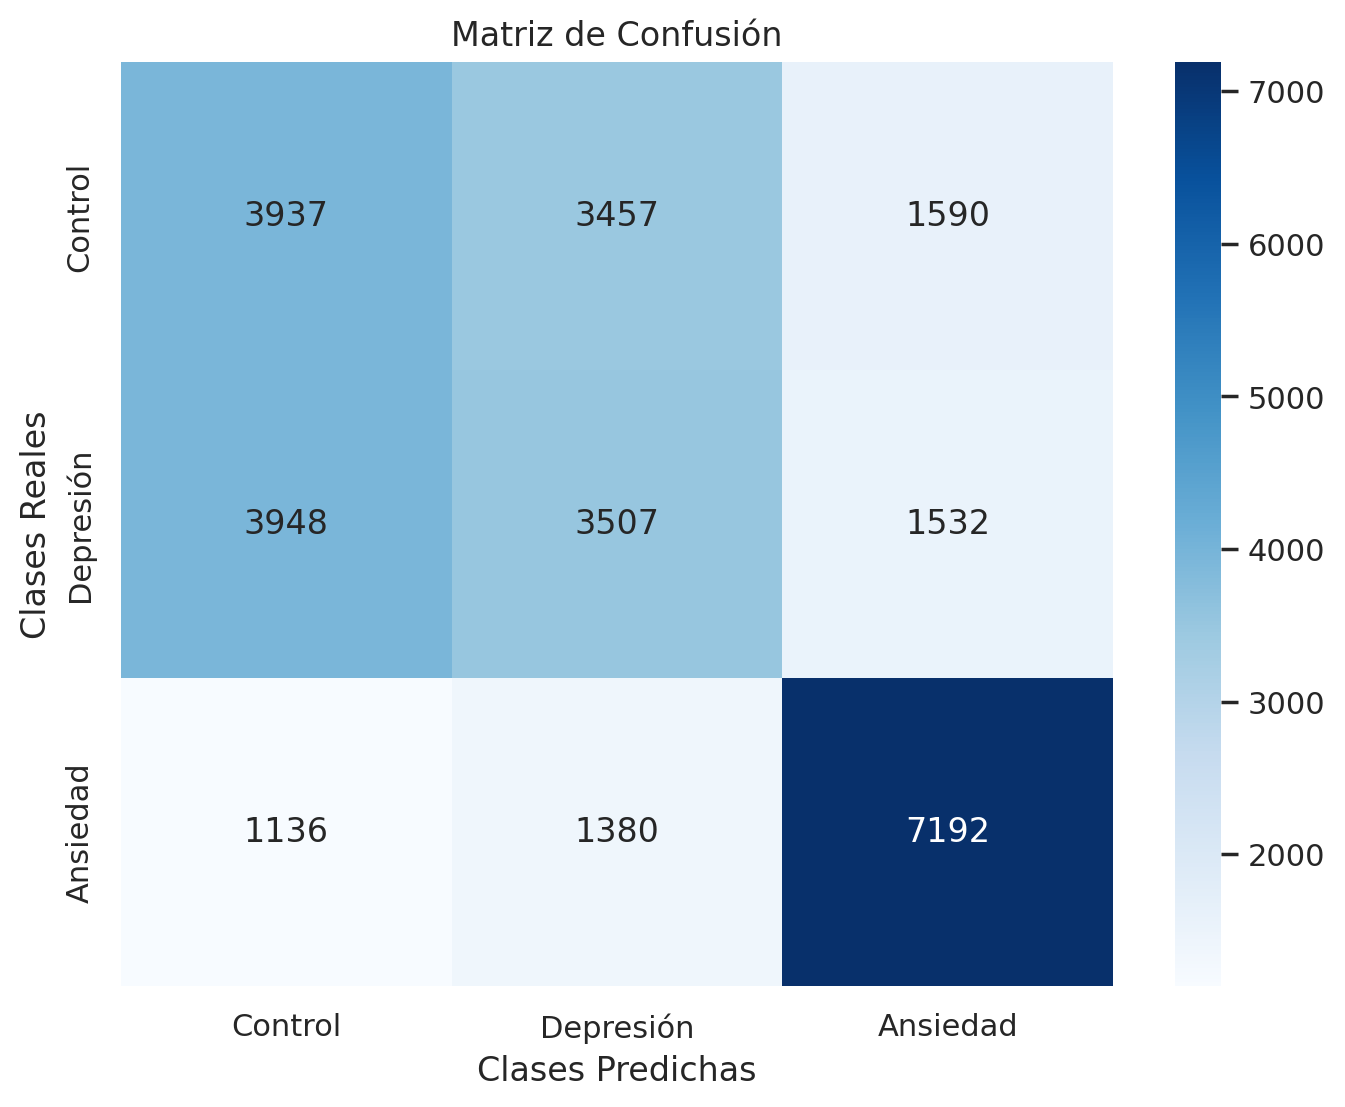

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Definir etiquetas de las clases
classes = ['Control', 'Depresión', 'Ansiedad']

# Crear un mapa de calor de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)

# Agregar etiquetas y título
plt.xlabel('Clases Predichas')
plt.ylabel('Clases Reales')
plt.title('Matriz de Confusión')

plt.show()